# Eventador Brewery Example

For this example we will do some hypothetical brewery automation based on real time sensor data. Sensors on beer mash tuns gather the current temperature levels and produce it to the pipeline. The data is then aggregated in real-time in PipelineDB. This allows the brewer to monitor the temperature levels and ensure it's below a particular threshold for good beer. If it gets out of threshold an actuator can reduce or increase the temperature.

Every notebook has a suite of helper commands that make life easier. These helpers already understand your login creds, endpoints and context. They can be referenced with ```e.help()```

In [1]:
e.help()


-------------------------------------------------------------------------------
Eventador Notebooks
-------------------------------------------------------------------------------

To run a method in a cell, press <alt>-<enter> or click the play button.

Built-ins:

clear_output()          Clear output of current cell
display()               Format output
plt                     Matplotlib Pyplot context

Valid Eventador methods:

# Kafka

e.kafka                 Return a PyKafka connection object
e.kafka_connect_string  Return Kafka connect string to use in applications
e.kfetch(topic)         Return sample documents (default: 5) from topic [ex: e.kfetch('my_messages')]
e.publish(topic, doc)   Publish a single document (from a dictionary) to topic
e.topics                List topics in Kafka

# PipelineDB

e.columns(table)        List columns for table or view
e.db                    Return a psycopg2 connection object
e.dc                    Return a psycopg2 DictCursor object
e.que

### Inspect the data coming into the pipeline. Let's pull a few messages

In [2]:
for i in range(1, 10):
    e.kfetch('defaultsink')

{u'sensor': u'MashTun1', u'temp': 83}
{u'sensor': u'MashTun2', u'temp': 50}
{u'sensor': u'MashTun1', u'temp': 42}
{u'sensor': u'MashTun2', u'temp': 44}
{u'sensor': u'MashTun2', u'temp': 58}
{u'sensor': u'MashTun1', u'temp': 83}
{u'sensor': u'MashTun1', u'temp': 42}
{u'sensor': u'MashTun2', u'temp': 58}
{u'sensor': u'MashTun2', u'temp': 45}
{u'sensor': u'MashTun1', u'temp': 41}
{u'sensor': u'MashTun1', u'temp': 83}
{u'sensor': u'MashTun2', u'temp': 50}
{u'sensor': u'MashTun1', u'temp': 42}
{u'sensor': u'MashTun1', u'temp': 41}
{u'sensor': u'MashTun2', u'temp': 44}
{u'sensor': u'MashTun1', u'temp': 83}
{u'sensor': u'MashTun1', u'temp': 42}
{u'sensor': u'MashTun2', u'temp': 44}
{u'sensor': u'MashTun2', u'temp': 58}
{u'sensor': u'MashTun2', u'temp': 45}
{u'sensor': u'MashTun1', u'temp': 83}
{u'sensor': u'MashTun1', u'temp': 42}
{u'sensor': u'MashTun2', u'temp': 45}
{u'sensor': u'MashTun1', u'temp': 41}
{u'sensor': u'MashTun2', u'temp': 70}
{u'sensor': u'MashTun1', u'temp': 83}
{u'sensor': 

### Display the continuous views we have (created as part of the getting started guide)

In [3]:
display(e.df(e.views))

,0
0,ev_sample_view
1,brewery_sensor_temps
2,brewery_temps_by_hourofday
3,brewery_sensor_temps_by_second
4,brewery_sensor_by_minute


### Setup the SQL we will be running

In [4]:
sql = "select * from brewery_sensor_temps"

### Test query the continuous view

In [5]:
display(e.df(e.query(sql)))

,avg,sensor
0,60.3064516129032258,MashTun1
1,62.4193548387096774,MashTun2


### Tell us if temperatures are out of spec, page the brewmaster. The continuous view is the last 5 minutes of rolling temperature averages.

In [6]:
import pandas as pd
df = pd.DataFrame(e.query(sql))
df['alert'] = False
for index, row in df.iterrows():
    if row.avg < 59 or row.avg > 62:
       df.set_value(index, 'alert', True)
       ''' perhaps we page the brewmaster
           page_brewmaster(df['sensor'], df['avg'])
       '''
display(df)

,avg,sensor,alert
0,60.3064516129032258,MashTun1,False
1,62.4193548387096774,MashTun2,True


### Adjust the temperature using controller API

In [7]:
target_temp = 60
df = pd.DataFrame(e.query(sql))
for index, row in df.iterrows():
    if row.avg < 59 or row.avg > 62:
       delta = target_temp-row.avg
       ''' throttle the heating equipment
           element.set_target_adjust(delta)
       '''
       print "need adjustment: element by {}".format(delta)

need adjustment: element by -2.4193548387096774


### Watch the data stream in real time by sensor.

In [8]:
import time
sql = "select * from brewery_sensor_temps"
df = pd.DataFrame(e.query(sql))
display(df)
for i in range(1, 20):
    u = pd.DataFrame(e.query(sql))
    df.update(u)
    clear_output()
    display(df)
    time.sleep(1)

,avg,sensor
0,59.7936507936507937,MashTun1
1,62.8412698412698413,MashTun2


In [9]:
sql = "select * from brewery_sensor_temps"
df = pd.DataFrame(e.query(sql))
display(df)

,avg,sensor
0,59.7936507936507937,MashTun1
1,62.8412698412698413,MashTun2


### Create a graph of temperatures by device over time

In [10]:
sql = "select * from brewery_sensor_temps_by_minute"
df = pd.DataFrame(e.query(sql))
cols = ['ts','sensor','avg']
df = df[cols]
df.avg = df.avg.astype(float)
df.head(3)

,ts,sensor,avg
0,2016-10-07 16:57:00+00:00,MashTun1,62.884615
1,2016-10-07 17:03:00+00:00,MashTun1,64.692308
2,2016-10-07 17:20:00+00:00,MashTun1,64.000000


In [11]:
df = df.pivot('ts','sensor','avg')
del df.index.name

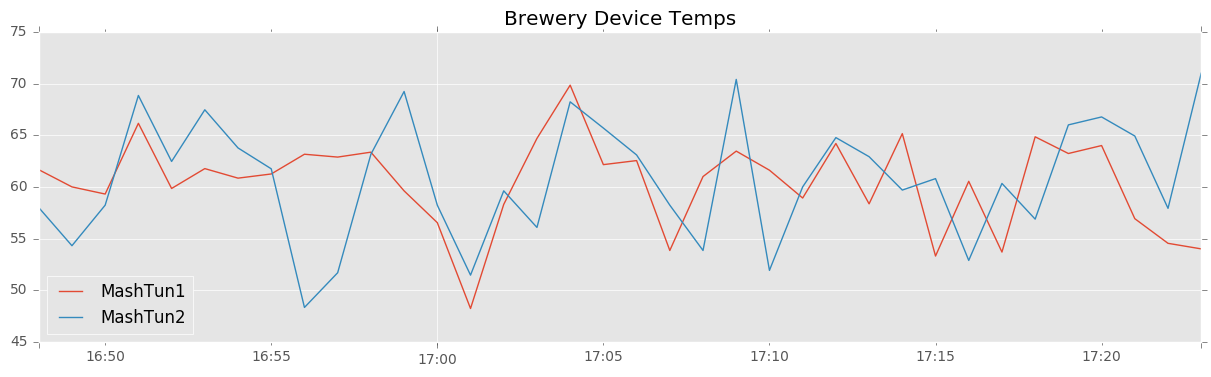

In [12]:
plt.figure();
df.plot(figsize=(15, 4), title="Brewery Device Temps");
plt.legend(loc=3)
plt.show()